In [2]:
import numpy as np
import pandas as pd
import requests

from plotnine import *

# source: https://gist.github.com/rogerallen/1583593
us_state_abbrev = requests.get('https://raw.githubusercontent.com/jwhendy/covid19/master/lib/state_abbrevs.json').json()
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [330]:
dat_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
                         parse_dates=['date'])
dat_county = dat_county[-dat_county['fips'].isna()]
dat_county['fips'] = dat_county['fips'].astype(int)

pop = pd.read_csv('https://raw.githubusercontent.com/jwhendy/covid19/master/data/population.csv')[['fips', 'pop']]
land = pd.read_csv('https://raw.githubusercontent.com/jwhendy/covid19/master/data/land_sqm.csv')[['fips', 'land_sqm']]
age = pd.read_csv('https://raw.githubusercontent.com/jwhendy/covid19/master/data/age_median.csv')[['fips', 'age_med']]
inc = pd.read_csv('https://raw.githubusercontent.com/jwhendy/covid19/master/data/income_median.csv')[['fips', 'inc_med']]

dat_m = dat_county.merge(pop, on='fips')
dat_m = dat_m.merge(land, on='fips')
dat_m['rho'] = dat_m['pop']/dat_m['land_sqm']
dat_m['cases_pop'] = dat_m['cases'] / dat_m['pop']
dat_m['rho_log'] = np.log10(dat_m['rho'])
dat_m['grp'] = dat_m['state'] + '_' + dat_m['county']
#dat_sub = dat_m[(dat_m['fips']==17031) & (dat_sub['cases'] > 10)]
#dat_m.groupby('fips').apply(lambda x: (x['date']-x['date'].min()).dt.days)
dat_m['dt'] = dat_m.groupby('fips', sort=False).apply(lambda x: (x['date']-x['date'].max()).dt.days).reset_index(name='dt', drop=True)
dat_m.head()

HTTPError: HTTP Error 404: Not Found

/home/jwhendy/.local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


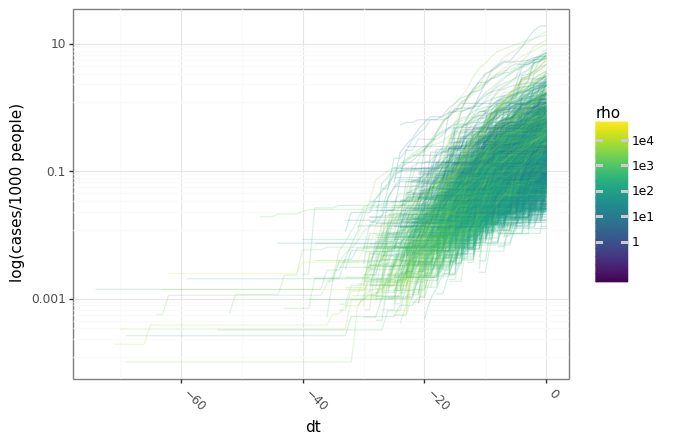

<ggplot: (8750967131293)>

In [310]:
size_cut = 1000
dat_m['size'] = [None]*len(dat_m)
dat_m.loc[dat_m['rho'] <= size_cut, 'size'] = 'small'
dat_m.loc[dat_m['rho'] > size_cut, 'size'] = 'big'

### won't currently work: https://github.com/has2k1/plotnine/issues/159
#p = ggplot(dat_m, aes(x='date', y='cases_pop*1000', color='rho', group='grp')) + geom_line(alpha=0.2, size=0.5)
#p = p + scale_x_datetime(breaks=['2020-01-30', '2020-02-15', '2020-02-29', '2020-03-15', '2020-03-30'])
#p = p + scale_color_cmap(trans='log10', breaks=[10**i for i in range(0, 5)])
#p = p + guides(color=guide_colorbar(title='pop/sqm'))
p = ggplot(dat_m, aes(x='dt', y='cases_pop*1000', color='rho', group='grp')) + geom_line(alpha=0.2, size=0.5)
p = p + scale_color_cmap(trans='log10', breaks=[10**i for i in range(0, 5)])
### uncomment to facet by big vs small
#p = p + facet_grid('size~.')
### uncomment to plot by date
p = p + scale_y_log10(name='log(cases/1000 people)')
p = p + theme_bw() + theme(axis_text_x = element_text(angle=315, hjust=0))
#p.save('plots/date-vs-cases.png', dpi=200, width=9, height=6)
p

In [283]:
def find_exp_fit(df, thresh=10):
    """Finds polyfot coefficients for y = A + 10**(Bx). In this case, y=cases, x=population density.
    Rearranging, log10(y) = log10(A) + Bx
    Method found here: https://stackoverflow.com/a/3433503/495990
    """
    tmp = df.copy()
    tmp = tmp.loc[tmp['cases']>thresh]
    if len(tmp) < 4:
        return None
    b, a = np.polyfit(tmp['dt'], np.log10(tmp['cases']), deg=1, w=np.sqrt(tmp['cases']))
    return pd.DataFrame({'cases_max': [tmp['cases'].max()],
                         'deaths_max': [tmp['deaths'].max()],
                         'dt_max': [tmp['dt'].max()],
                         'a': [a],
                         'b': [b]})

thresh=25
dat_agg = dat_m.groupby(['state', 'county', 'fips', 'pop', 'land_sqm', 'rho']).apply(find_exp_fit, (thresh)).reset_index()
dat_agg = dat_agg.drop(columns='level_6')
dat_agg['grp'] = dat_agg['state'] + '_' + dat_agg['county']
dat_agg['cases_pop'] = dat_agg['cases_max'] / dat_agg['pop']
dat_agg['deaths_pop'] = dat_agg['deaths_max'] / dat_agg['pop']
dat_agg['rho_log'] = np.log10(dat_agg['rho'])

print(dat_agg.rho.max())
dat_agg.head()

17180.179219116708


,state,county,fips,pop,land_sqm,rho,cases_max,deaths_max,dt_max,a,b,grp,cases_pop,deaths_pop,rho_log
0,Alabama,Chambers,1017,34215,596.53,57.356713,87,6,16,0.540758,0.089101,Alabama_Chambers,0.002543,0.000175,1.758584
1,Alabama,Jefferson,1073,658466,1111.28,592.529336,376,9,22,1.435049,0.055036,Alabama_Jefferson,0.000571,0.000014,2.772710
2,Alabama,Lee,1081,140247,607.54,230.844060,104,3,20,1.163245,0.044033,Alabama_Lee,0.000742,0.000021,2.363319
3,Alabama,Madison,1089,334811,801.59,417.683604,126,1,18,1.278350,0.048706,Alabama_Madison,0.000376,0.000003,2.620847
4,Alabama,Mobile,1097,412992,1229.44,335.918792,114,5,16,0.793471,0.078480,Alabama_Mobile,0.000276,0.000012,2.526234


In [257]:
### test linear model on a real county
df_tmp = dat_m[(dat_m['fips']==17031) & (dat_m['cases']>thresh)]
print(df_tmp.head())
foo = find_exp_fit(df_tmp)
print(foo)
print(10**(foo.a + foo.b*71))

          date county     state   fips  cases  deaths      pop  land_sqm  \
120 2020-03-09   Cook  Illinois  17031     11       0  5194675    945.33   
121 2020-03-10   Cook  Illinois  17031     17       0  5194675    945.33   
122 2020-03-11   Cook  Illinois  17031     22       0  5194675    945.33   
123 2020-03-12   Cook  Illinois  17031     27       0  5194675    945.33   
124 2020-03-13   Cook  Illinois  17031     40       0  5194675    945.33   

             rho  cases_pop   rho_log            grp  dt  
120  5495.091661   0.000002  3.739975  Illinois_Cook  45  
121  5495.091661   0.000003  3.739975  Illinois_Cook  46  
122  5495.091661   0.000004  3.739975  Illinois_Cook  47  
123  5495.091661   0.000005  3.739975  Illinois_Cook  48  
124  5495.091661   0.000008  3.739975  Illinois_Cook  49  
   cases_max  deaths_max  dt_max         a         b
0       7439         167      71 -1.802539  0.080783
0    8570.804084
dtype: float64


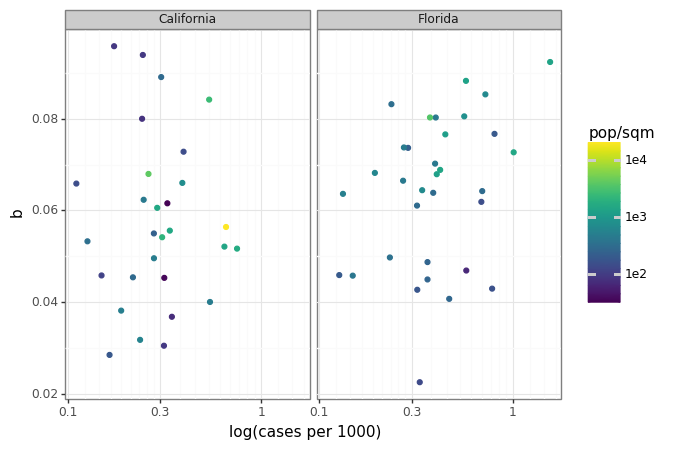

<ggplot: (8750953377654)>

In [321]:
dat_agg_sub = dat_agg[(dat_agg['state']=='California') | (dat_agg['state']=='Florida')]
p = ggplot(dat_agg_sub, aes(x='cases_pop*1000', y='b', color='rho')) + geom_point() + facet_grid('~state')
p = p + scale_x_log10(name='log(cases per 1000)')
p = p + scale_color_cmap(trans='log10')
#p = p + scale_y_log10()
p = p + guides(color=guide_colorbar(title='pop/sqm'))
#p = ggplot(dat_agg, aes(x='rho', y='b', color='pop')) + geom_point() + scale_x_log10() + scale_color_cmap(trans='log10')
p = p + theme_bw()
### uncomment to crop to max b of 0.1
#p = p + scale_y_continuous(limits=[0, 0.1])
#p.save('plots/exp-vs-density-crop.png', dpi=200, width=9, height=6)
p

In [263]:
print(dat_agg['pop'].max())
print(dat_agg['rho'].max())
print(dat_agg['cases_pop'].max())


dat_agg[dat_agg['b'] > 0.12]

9818605
17180.179219116708
0.019180389221556886


,state,county,fips,pop,land_sqm,rho,cases_max,deaths_max,dt_max,a,b,grp,cases_pop,deaths_pop,rho_log
227,Indiana,Bartholomew,18005,76794,406.91,188.724779,45,0,19,-1.302495,0.152719,Indiana_Bartholomew,0.000586,0.000000,2.275829
245,Indiana,Lawrence,18093,46134,449.17,102.709442,36,5,11,-0.544938,0.189785,Indiana_Lawrence,0.000780,0.000108,2.011610
307,Louisiana,St. Charles,22089,52780,279.08,189.121399,252,12,22,-0.352535,0.125697,Louisiana_St. Charles,0.004775,0.000227,2.276741
314,Louisiana,Tangipahoa,22105,121097,791.28,153.039379,131,2,15,-0.632124,0.179351,Louisiana_Tangipahoa,0.001082,0.000017,2.184803
443,Nebraska,Hall,31079,58607,546.29,107.281847,40,1,9,0.268150,0.147164,Nebraska_Hall,0.000683,0.000017,2.030526
581,Ohio,Wayne,39169,114520,554.93,206.368371,25,0,10,0.059873,0.132690,Ohio_Wayne,0.000218,0.000000,2.314643
594,Oklahoma,Wagoner,40145,73085,561.56,130.146378,40,2,11,0.158224,0.131892,Oklahoma_Wagoner,0.000547,0.000027,2.114432
626,Pennsylvania,Lehigh,42077,349497,345.17,1012.535852,804,7,20,0.458451,0.122829,Pennsylvania_Lehigh,0.002300,0.000020,3.005410
627,Pennsylvania,Luzerne,42079,320918,890.33,360.448373,648,5,20,0.115406,0.135760,Pennsylvania_Luzerne,0.002019,0.000016,2.556843
752,Virginia,Hampton city,51650,137436,51.41,2673.332037,39,0,9,0.364253,0.134860,Virginia_Hampton city,0.000284,0.000000,3.427053
